# PTN Template
This notebook serves as a template for single dataset PTN experiments  
It can be run on its own by setting STANDALONE to True (do a find for "STANDALONE" to see where)  
But it is intended to be executed as part of a *papermill.py script. See any of the   
experimentes with a papermill script to get started with that workflow.  

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

    
import os, json, sys, time, random
import numpy as np
import torch
from torch.optim import Adam
from  easydict import EasyDict
import matplotlib.pyplot as plt

from steves_models.steves_ptn import Steves_Prototypical_Network

from steves_utils.lazy_iterable_wrapper import Lazy_Iterable_Wrapper
from steves_utils.iterable_aggregator import Iterable_Aggregator
from steves_utils.ptn_train_eval_test_jig import  PTN_Train_Eval_Test_Jig
from steves_utils.torch_sequential_builder import build_sequential
from steves_utils.torch_utils import get_dataset_metrics, ptn_confusion_by_domain_over_dataloader
from steves_utils.utils_v2 import (per_domain_accuracy_from_confusion, get_datasets_base_path)
from steves_utils.PTN.utils import independent_accuracy_assesment

from steves_utils.stratified_dataset.episodic_accessor import Episodic_Accessor_Factory

from steves_utils.ptn_do_report import (
    get_loss_curve,
    get_results_table,
    get_parameters_table,
    get_domain_accuracies,
)

from steves_utils.transforms import get_chained_transform

# Required Parameters
These are allowed parameters, not defaults
Each of these values need to be present in the injected parameters (the notebook will raise an exception if they are not present)

Papermill uses the cell tag "parameters" to inject the real parameters below this cell.
Enable tags to see what I mean

In [2]:
required_parameters = {
    "experiment_name",
    "lr",
    "device",
    "seed",
    "dataset_seed",
    "labels_source",
    "labels_target",
    "domains_source",
    "domains_target",
    "num_examples_per_domain_per_label_source",
    "num_examples_per_domain_per_label_target",
    "n_shot",
    "n_way",
    "n_query",
    "train_k_factor",
    "val_k_factor",
    "test_k_factor",
    "n_epoch",
    "patience",
    "criteria_for_best",
    "x_transforms_source",
    "x_transforms_target",
    "episode_transforms_source",
    "episode_transforms_target",
    "pickle_name",
    "x_net",
    "NUM_LOGS_PER_EPOCH",
    "BEST_MODEL_PATH",
    "torch_default_dtype"
}

In [3]:


standalone_parameters = {}
standalone_parameters["experiment_name"] = "STANDALONE PTN"
standalone_parameters["lr"] = 0.0001
standalone_parameters["device"] = "cuda"

standalone_parameters["seed"] = 1337
standalone_parameters["dataset_seed"] = 1337


standalone_parameters["num_examples_per_domain_per_label_source"]=100
standalone_parameters["num_examples_per_domain_per_label_target"]=100

standalone_parameters["n_shot"] = 3
standalone_parameters["n_query"]  = 2
standalone_parameters["train_k_factor"] = 1
standalone_parameters["val_k_factor"] = 2
standalone_parameters["test_k_factor"] = 2


standalone_parameters["n_epoch"] = 100

standalone_parameters["patience"] = 10
standalone_parameters["criteria_for_best"] = "target_accuracy"

standalone_parameters["x_transforms_source"] = ["unit_power"]
standalone_parameters["x_transforms_target"] = ["unit_power"]
standalone_parameters["episode_transforms_source"] = []
standalone_parameters["episode_transforms_target"] = []

standalone_parameters["torch_default_dtype"] = "torch.float32" 



standalone_parameters["x_net"] =     [
    {"class": "nnReshape", "kargs": {"shape":[-1, 1, 2, 256]}},
    {"class": "Conv2d", "kargs": { "in_channels":1, "out_channels":256, "kernel_size":(1,7), "bias":False, "padding":(0,3), },},
    {"class": "ReLU", "kargs": {"inplace": True}},
    {"class": "BatchNorm2d", "kargs": {"num_features":256}},

    {"class": "Conv2d", "kargs": { "in_channels":256, "out_channels":80, "kernel_size":(2,7), "bias":True, "padding":(0,3), },},
    {"class": "ReLU", "kargs": {"inplace": True}},
    {"class": "BatchNorm2d", "kargs": {"num_features":80}},
    {"class": "Flatten", "kargs": {}},

    {"class": "Linear", "kargs": {"in_features": 80*256, "out_features": 256}}, # 80 units per IQ pair
    {"class": "ReLU", "kargs": {"inplace": True}},
    {"class": "BatchNorm1d", "kargs": {"num_features":256}},

    {"class": "Linear", "kargs": {"in_features": 256, "out_features": 256}},
]

# Parameters relevant to results
# These parameters will basically never need to change
standalone_parameters["NUM_LOGS_PER_EPOCH"] = 10
standalone_parameters["BEST_MODEL_PATH"] = "./best_model.pth"

# uncomment for CORES dataset
from steves_utils.CORES.utils import (
    ALL_NODES,
    ALL_NODES_MINIMUM_1000_EXAMPLES,
    ALL_DAYS
)


standalone_parameters["labels_source"] = ALL_NODES
standalone_parameters["labels_target"] = ALL_NODES

standalone_parameters["domains_source"] = [1]
standalone_parameters["domains_target"] = [2,3,4,5]

standalone_parameters["pickle_name"] = "cores.stratified_ds.2022A.pkl"


# Uncomment these for ORACLE dataset
# from steves_utils.ORACLE.utils_v2 import (
#     ALL_DISTANCES_FEET,
#     ALL_RUNS,
#     ALL_SERIAL_NUMBERS,
# )
# standalone_parameters["labels_source"] = ALL_SERIAL_NUMBERS
# standalone_parameters["labels_target"] = ALL_SERIAL_NUMBERS
# standalone_parameters["domains_source"] = [8,20, 38,50]
# standalone_parameters["domains_target"] = [14, 26, 32, 44, 56]
# standalone_parameters["pickle_name"] = "oracle.frame_indexed.stratified_ds.2022A.pkl"
# standalone_parameters["num_examples_per_domain_per_label_source"]=1000
# standalone_parameters["num_examples_per_domain_per_label_target"]=1000

# Uncomment these for Metahan dataset
# standalone_parameters["labels_source"] = list(range(19))
# standalone_parameters["labels_target"] = list(range(19))
# standalone_parameters["domains_source"] = [0]
# standalone_parameters["domains_target"] = [1]
# standalone_parameters["pickle_name"] = "metehan.stratified_ds.2022A.pkl"
# standalone_parameters["n_way"]  = len(standalone_parameters["labels_source"])
# standalone_parameters["num_examples_per_domain_per_label_source"]=200
# standalone_parameters["num_examples_per_domain_per_label_target"]=100


standalone_parameters["n_way"]  = len(standalone_parameters["labels_source"])

In [4]:
# Parameters
parameters = {
    "experiment_name": "baseline_ptn_oracle.run2.framed",
    "lr": 0.001,
    "device": "cuda",
    "seed": 1337,
    "dataset_seed": 1337,
    "labels_source": [
        "3123D52",
        "3123D65",
        "3123D79",
        "3123D80",
        "3123D54",
        "3123D70",
        "3123D7B",
        "3123D89",
        "3123D58",
        "3123D76",
        "3123D7D",
        "3123EFE",
        "3123D64",
        "3123D78",
        "3123D7E",
        "3124E4A",
    ],
    "labels_target": [
        "3123D52",
        "3123D65",
        "3123D79",
        "3123D80",
        "3123D54",
        "3123D70",
        "3123D7B",
        "3123D89",
        "3123D58",
        "3123D76",
        "3123D7D",
        "3123EFE",
        "3123D64",
        "3123D78",
        "3123D7E",
        "3124E4A",
    ],
    "x_transforms_source": [],
    "x_transforms_target": [],
    "episode_transforms_source": [],
    "episode_transforms_target": [],
    "num_examples_per_domain_per_label_source": 1000,
    "num_examples_per_domain_per_label_target": 1000,
    "n_shot": 3,
    "n_way": 16,
    "n_query": 2,
    "train_k_factor": 1,
    "val_k_factor": 2,
    "test_k_factor": 2,
    "torch_default_dtype": "torch.float64",
    "n_epoch": 50,
    "patience": 3,
    "criteria_for_best": "target_loss",
    "x_net": [
        {"class": "nnReshape", "kargs": {"shape": [-1, 1, 2, 256]}},
        {
            "class": "Conv2d",
            "kargs": {
                "in_channels": 1,
                "out_channels": 256,
                "kernel_size": [1, 7],
                "bias": False,
                "padding": [0, 3],
            },
        },
        {"class": "ReLU", "kargs": {"inplace": True}},
        {"class": "BatchNorm2d", "kargs": {"num_features": 256}},
        {
            "class": "Conv2d",
            "kargs": {
                "in_channels": 256,
                "out_channels": 80,
                "kernel_size": [2, 7],
                "bias": True,
                "padding": [0, 3],
            },
        },
        {"class": "ReLU", "kargs": {"inplace": True}},
        {"class": "BatchNorm2d", "kargs": {"num_features": 80}},
        {"class": "Flatten", "kargs": {}},
        {"class": "Linear", "kargs": {"in_features": 20480, "out_features": 256}},
        {"class": "ReLU", "kargs": {"inplace": True}},
        {"class": "BatchNorm1d", "kargs": {"num_features": 256}},
        {"class": "Linear", "kargs": {"in_features": 256, "out_features": 256}},
    ],
    "NUM_LOGS_PER_EPOCH": 10,
    "BEST_MODEL_PATH": "./best_model.pth",
    "pickle_name": "oracle.Run2_framed_2000Examples_stratified_ds.2022A.pkl",
    "domains_source": [8, 32, 50],
    "domains_target": [14, 20, 26, 38, 44],
}


In [5]:
# Set this to True if you want to run this template directly
STANDALONE = False
if STANDALONE:
    print("parameters not injected, running with standalone_parameters")
    parameters = standalone_parameters

if not 'parameters' in locals() and not 'parameters' in globals():
    raise Exception("Parameter injection failed")

#Use an easy dict for all the parameters
p = EasyDict(parameters)

supplied_keys = set(p.keys())

if  supplied_keys != required_parameters:
    print("Parameters are incorrect")
    if len(supplied_keys - required_parameters)>0: print("Shouldn't have:", str(supplied_keys - required_parameters))
    if len(required_parameters - supplied_keys)>0: print("Need to have:", str(required_parameters - supplied_keys))
    raise RuntimeError("Parameters are incorrect")



In [6]:
###################################
# Set the RNGs and make it all deterministic
###################################
np.random.seed(p.seed)
random.seed(p.seed)
torch.manual_seed(p.seed)

torch.use_deterministic_algorithms(True) 

In [7]:
###########################################
# The stratified datasets honor this
###########################################
torch.set_default_dtype(eval(p.torch_default_dtype))

In [8]:
###################################
# Build the network(s)
# Note: It's critical to do this AFTER setting the RNG
# (This is due to the randomized initial weights)
###################################
x_net = build_sequential(p.x_net)

In [9]:
start_time_secs = time.time()

In [10]:
###################################
# Build the dataset
###################################

if p.x_transforms_source == []: x_transform_source = None
else: x_transform_source = get_chained_transform(p.x_transforms_source) 

if p.x_transforms_target == []: x_transform_target = None
else: x_transform_target = get_chained_transform(p.x_transforms_target)

if p.episode_transforms_source == []: episode_transform_source = None
else: raise Exception("episode_transform_source not implemented")

if p.episode_transforms_target == []: episode_transform_target = None
else: raise Exception("episode_transform_target not implemented")


eaf_source = Episodic_Accessor_Factory(
    labels=p.labels_source,
    domains=p.domains_source,
    num_examples_per_domain_per_label=p.num_examples_per_domain_per_label_source,
    iterator_seed=p.seed,
    dataset_seed=p.dataset_seed,
    n_shot=p.n_shot,
    n_way=p.n_way,
    n_query=p.n_query,
    train_val_test_k_factors=(p.train_k_factor,p.val_k_factor,p.test_k_factor),
    pickle_path=os.path.join(get_datasets_base_path(), p.pickle_name),
    x_transform_func=x_transform_source,
    example_transform_func=episode_transform_source,
    
)
train_original_source, val_original_source, test_original_source = eaf_source.get_train(), eaf_source.get_val(), eaf_source.get_test()


eaf_target = Episodic_Accessor_Factory(
    labels=p.labels_target,
    domains=p.domains_target,
    num_examples_per_domain_per_label=p.num_examples_per_domain_per_label_target,
    iterator_seed=p.seed,
    dataset_seed=p.dataset_seed,
    n_shot=p.n_shot,
    n_way=p.n_way,
    n_query=p.n_query,
    train_val_test_k_factors=(p.train_k_factor,p.val_k_factor,p.test_k_factor),
    pickle_path=os.path.join(get_datasets_base_path(), p.pickle_name),
    x_transform_func=x_transform_target,
    example_transform_func=episode_transform_target,
)
train_original_target, val_original_target, test_original_target = eaf_target.get_train(), eaf_target.get_val(), eaf_target.get_test()


transform_lambda = lambda ex: ex[1] # Original is (<domain>, <episode>) so we strip down to episode only

train_processed_source = Lazy_Iterable_Wrapper(train_original_source, transform_lambda)
val_processed_source   = Lazy_Iterable_Wrapper(val_original_source, transform_lambda)
test_processed_source  = Lazy_Iterable_Wrapper(test_original_source, transform_lambda)

train_processed_target = Lazy_Iterable_Wrapper(train_original_target, transform_lambda)
val_processed_target   = Lazy_Iterable_Wrapper(val_original_target, transform_lambda)
test_processed_target  = Lazy_Iterable_Wrapper(test_original_target, transform_lambda)

datasets = EasyDict({
    "source": {
        "original": {"train":train_original_source, "val":val_original_source, "test":test_original_source},
        "processed": {"train":train_processed_source, "val":val_processed_source, "test":test_processed_source}
    },
    "target": {
        "original": {"train":train_original_target, "val":val_original_target, "test":test_original_target},
        "processed": {"train":train_processed_target, "val":val_processed_target, "test":test_processed_target}
    },
})

In [11]:
# Some quick unit tests on the data
from steves_utils.transforms import get_average_power, get_average_magnitude

q_x, q_y, s_x, s_y, truth = next(iter(train_processed_source))

assert q_x.dtype == eval(p.torch_default_dtype)
assert s_x.dtype == eval(p.torch_default_dtype)

print("Visually inspect these to see if they line up with expected values given the transforms")
print('x_transforms_source', p.x_transforms_source)
print('x_transforms_target', p.x_transforms_target)
print("Average magnitude, source:", get_average_magnitude(q_x[0].numpy()))
print("Average power, source:", get_average_power(q_x[0].numpy()))

q_x, q_y, s_x, s_y, truth = next(iter(train_processed_target))
print("Average magnitude, target:", get_average_magnitude(q_x[0].numpy()))
print("Average power, target:", get_average_power(q_x[0].numpy()))


Visually inspect these to see if they line up with expected values given the transforms
x_transforms_source []
x_transforms_target []
Average magnitude, source: 0.005257917777152619
Average power, source: 2.976282599594409e-05


Average magnitude, target: 0.003187320462977413
Average power, target: 1.111527480981822e-05


In [12]:
###################################
# Build the model
###################################
model = Steves_Prototypical_Network(x_net, device=p.device, x_shape=(2,256))
optimizer = Adam(params=model.parameters(), lr=p.lr)

(2, 256)


In [13]:
###################################
# train
###################################
jig = PTN_Train_Eval_Test_Jig(model, p.BEST_MODEL_PATH, p.device)

jig.train(
    train_iterable=datasets.source.processed.train,
    source_val_iterable=datasets.source.processed.val,
    target_val_iterable=datasets.target.processed.val,
    num_epochs=p.n_epoch,
    num_logs_per_epoch=p.NUM_LOGS_PER_EPOCH,
    patience=p.patience,
    optimizer=optimizer,
    criteria_for_best=p.criteria_for_best,
)

epoch: 1, [batch: 1 / 420], examples_per_second: 171.5520, train_label_loss: 2.5592, 


epoch: 1, [batch: 42 / 420], examples_per_second: 258.1545, train_label_loss: 1.0475, 


epoch: 1, [batch: 84 / 420], examples_per_second: 258.5935, train_label_loss: 0.4603, 


epoch: 1, [batch: 126 / 420], examples_per_second: 258.2583, train_label_loss: 0.7562, 


epoch: 1, [batch: 168 / 420], examples_per_second: 258.2654, train_label_loss: 0.5372, 


epoch: 1, [batch: 210 / 420], examples_per_second: 258.2687, train_label_loss: 0.1415, 


epoch: 1, [batch: 252 / 420], examples_per_second: 258.0540, train_label_loss: 0.8290, 


epoch: 1, [batch: 294 / 420], examples_per_second: 258.1879, train_label_loss: 0.2126, 


epoch: 1, [batch: 336 / 420], examples_per_second: 258.2174, train_label_loss: 0.1177, 


epoch: 1, [batch: 378 / 420], examples_per_second: 258.2599, train_label_loss: 0.2534, 


epoch: 1, source_val_acc_label: 0.5304, target_val_acc_label: 0.4592, source_val_label_loss: 122.3066, target_val_label_loss: 70.5319, 


New best


epoch: 2, [batch: 1 / 420], examples_per_second: 2.6942, train_label_loss: 1.3547, 


epoch: 2, [batch: 42 / 420], examples_per_second: 259.6622, train_label_loss: 8.9508, 


epoch: 2, [batch: 84 / 420], examples_per_second: 259.7955, train_label_loss: 117.9524, 


epoch: 2, [batch: 126 / 420], examples_per_second: 259.5170, train_label_loss: 1.5753, 


epoch: 2, [batch: 168 / 420], examples_per_second: 259.4403, train_label_loss: 56.3548, 


epoch: 2, [batch: 210 / 420], examples_per_second: 259.6092, train_label_loss: 15.4822, 


epoch: 2, [batch: 252 / 420], examples_per_second: 259.6529, train_label_loss: 1.4772, 


epoch: 2, [batch: 294 / 420], examples_per_second: 259.6297, train_label_loss: 7.6962, 


epoch: 2, [batch: 336 / 420], examples_per_second: 259.9758, train_label_loss: 41.1385, 


epoch: 2, [batch: 378 / 420], examples_per_second: 259.6361, train_label_loss: 19.1347, 


epoch: 2, source_val_acc_label: 0.8359, target_val_acc_label: 0.6790, source_val_label_loss: 19.6816, target_val_label_loss: 14.1226, 


New best


epoch: 3, [batch: 1 / 420], examples_per_second: 2.6936, train_label_loss: 40.4848, 


epoch: 3, [batch: 42 / 420], examples_per_second: 259.5630, train_label_loss: 0.6502, 


epoch: 3, [batch: 84 / 420], examples_per_second: 259.4278, train_label_loss: 14.5406, 


epoch: 3, [batch: 126 / 420], examples_per_second: 259.6278, train_label_loss: 0.5313, 


epoch: 3, [batch: 168 / 420], examples_per_second: 259.7454, train_label_loss: 0.9293, 


epoch: 3, [batch: 210 / 420], examples_per_second: 259.6226, train_label_loss: 0.3754, 


epoch: 3, [batch: 252 / 420], examples_per_second: 259.6709, train_label_loss: 0.5478, 


epoch: 3, [batch: 294 / 420], examples_per_second: 259.7252, train_label_loss: 19.0037, 


epoch: 3, [batch: 336 / 420], examples_per_second: 259.5593, train_label_loss: 17.1811, 


epoch: 3, [batch: 378 / 420], examples_per_second: 259.4900, train_label_loss: 0.1237, 


epoch: 3, source_val_acc_label: 0.8543, target_val_acc_label: 0.7390, source_val_label_loss: 4.4343, target_val_label_loss: 9.1917, 


New best


epoch: 4, [batch: 1 / 420], examples_per_second: 2.7069, train_label_loss: 1.4831, 


epoch: 4, [batch: 42 / 420], examples_per_second: 284.2526, train_label_loss: 7.6734, 


epoch: 4, [batch: 84 / 420], examples_per_second: 284.1362, train_label_loss: 0.6922, 


epoch: 4, [batch: 126 / 420], examples_per_second: 284.4095, train_label_loss: 6.2342, 


epoch: 4, [batch: 168 / 420], examples_per_second: 287.5184, train_label_loss: 7.7470, 


epoch: 4, [batch: 210 / 420], examples_per_second: 284.2286, train_label_loss: 0.0663, 


epoch: 4, [batch: 252 / 420], examples_per_second: 303.2234, train_label_loss: 4.0711, 


epoch: 4, [batch: 294 / 420], examples_per_second: 259.7453, train_label_loss: 3.5833, 


epoch: 4, [batch: 336 / 420], examples_per_second: 259.7105, train_label_loss: 12.0873, 


epoch: 4, [batch: 378 / 420], examples_per_second: 259.6384, train_label_loss: 1.0434, 


epoch: 4, source_val_acc_label: 0.8434, target_val_acc_label: 0.7101, source_val_label_loss: 1.2816, target_val_label_loss: 5.6298, 


New best


epoch: 5, [batch: 1 / 420], examples_per_second: 2.6929, train_label_loss: 0.3209, 


epoch: 5, [batch: 42 / 420], examples_per_second: 259.7188, train_label_loss: 0.5272, 


epoch: 5, [batch: 84 / 420], examples_per_second: 257.9236, train_label_loss: 0.0753, 


epoch: 5, [batch: 126 / 420], examples_per_second: 259.6009, train_label_loss: 0.0682, 


epoch: 5, [batch: 168 / 420], examples_per_second: 259.6344, train_label_loss: 0.4783, 


epoch: 5, [batch: 210 / 420], examples_per_second: 259.7946, train_label_loss: 0.6367, 


epoch: 5, [batch: 252 / 420], examples_per_second: 259.6430, train_label_loss: 0.1835, 


epoch: 5, [batch: 294 / 420], examples_per_second: 259.6823, train_label_loss: 0.6493, 


epoch: 5, [batch: 336 / 420], examples_per_second: 259.6904, train_label_loss: 0.6059, 


epoch: 5, [batch: 378 / 420], examples_per_second: 259.6543, train_label_loss: 1.1498, 


epoch: 5, source_val_acc_label: 0.8741, target_val_acc_label: 0.7436, source_val_label_loss: 0.5765, target_val_label_loss: 3.3810, 


New best


epoch: 6, [batch: 1 / 420], examples_per_second: 2.6936, train_label_loss: 0.2412, 


epoch: 6, [batch: 42 / 420], examples_per_second: 259.5289, train_label_loss: 0.2944, 


epoch: 6, [batch: 84 / 420], examples_per_second: 259.4505, train_label_loss: 0.7677, 


epoch: 6, [batch: 126 / 420], examples_per_second: 259.7209, train_label_loss: 0.1733, 


epoch: 6, [batch: 168 / 420], examples_per_second: 259.6663, train_label_loss: 0.3989, 


epoch: 6, [batch: 210 / 420], examples_per_second: 259.4596, train_label_loss: 0.9393, 


epoch: 6, [batch: 252 / 420], examples_per_second: 259.7854, train_label_loss: 0.3135, 


epoch: 6, [batch: 294 / 420], examples_per_second: 259.7027, train_label_loss: 0.8608, 


epoch: 6, [batch: 336 / 420], examples_per_second: 259.7415, train_label_loss: 0.2053, 


epoch: 6, [batch: 378 / 420], examples_per_second: 259.4707, train_label_loss: 0.2865, 


epoch: 6, source_val_acc_label: 0.8892, target_val_acc_label: 0.7475, source_val_label_loss: 0.4042, target_val_label_loss: 3.4742, 


epoch: 7, [batch: 1 / 420], examples_per_second: 2.7013, train_label_loss: 0.2449, 


epoch: 7, [batch: 42 / 420], examples_per_second: 259.6164, train_label_loss: 0.3821, 


epoch: 7, [batch: 84 / 420], examples_per_second: 259.5828, train_label_loss: 0.4972, 


epoch: 7, [batch: 126 / 420], examples_per_second: 259.7239, train_label_loss: 0.1626, 


epoch: 7, [batch: 168 / 420], examples_per_second: 259.6953, train_label_loss: 0.1606, 


epoch: 7, [batch: 210 / 420], examples_per_second: 259.8917, train_label_loss: 0.0737, 


epoch: 7, [batch: 252 / 420], examples_per_second: 259.5767, train_label_loss: 0.2154, 


epoch: 7, [batch: 294 / 420], examples_per_second: 259.4457, train_label_loss: 0.7031, 


epoch: 7, [batch: 336 / 420], examples_per_second: 259.8056, train_label_loss: 0.0775, 


epoch: 7, [batch: 378 / 420], examples_per_second: 259.6283, train_label_loss: 0.2139, 


epoch: 7, source_val_acc_label: 0.9030, target_val_acc_label: 0.7638, source_val_label_loss: 0.2926, target_val_label_loss: 3.1984, 


New best


epoch: 8, [batch: 1 / 420], examples_per_second: 2.6921, train_label_loss: 0.1807, 


epoch: 8, [batch: 42 / 420], examples_per_second: 259.6010, train_label_loss: 0.2825, 


epoch: 8, [batch: 84 / 420], examples_per_second: 259.7294, train_label_loss: 0.2701, 


epoch: 8, [batch: 126 / 420], examples_per_second: 259.6500, train_label_loss: 0.5022, 


epoch: 8, [batch: 168 / 420], examples_per_second: 259.6736, train_label_loss: 0.2047, 


epoch: 8, [batch: 210 / 420], examples_per_second: 259.4409, train_label_loss: 0.1833, 


epoch: 8, [batch: 252 / 420], examples_per_second: 259.5013, train_label_loss: 0.4085, 


epoch: 8, [batch: 294 / 420], examples_per_second: 259.7133, train_label_loss: 0.2375, 


epoch: 8, [batch: 336 / 420], examples_per_second: 259.4562, train_label_loss: 0.3709, 


epoch: 8, [batch: 378 / 420], examples_per_second: 259.7117, train_label_loss: 0.3562, 


epoch: 8, source_val_acc_label: 0.9122, target_val_acc_label: 0.7835, source_val_label_loss: 0.2737, target_val_label_loss: 2.0224, 


New best


epoch: 9, [batch: 1 / 420], examples_per_second: 2.9651, train_label_loss: 0.5678, 


epoch: 9, [batch: 42 / 420], examples_per_second: 285.5493, train_label_loss: 0.2379, 


epoch: 9, [batch: 84 / 420], examples_per_second: 284.3065, train_label_loss: 0.1437, 


epoch: 9, [batch: 126 / 420], examples_per_second: 294.8397, train_label_loss: 0.3182, 


epoch: 9, [batch: 168 / 420], examples_per_second: 259.6788, train_label_loss: 0.5141, 


epoch: 9, [batch: 210 / 420], examples_per_second: 259.7766, train_label_loss: 0.1148, 


epoch: 9, [batch: 252 / 420], examples_per_second: 259.6898, train_label_loss: 0.1713, 


epoch: 9, [batch: 294 / 420], examples_per_second: 259.6956, train_label_loss: 0.2053, 


epoch: 9, [batch: 336 / 420], examples_per_second: 259.6329, train_label_loss: 0.2154, 


epoch: 9, [batch: 378 / 420], examples_per_second: 259.7223, train_label_loss: 0.5889, 


epoch: 9, source_val_acc_label: 0.9137, target_val_acc_label: 0.7922, source_val_label_loss: 0.2631, target_val_label_loss: 2.5247, 


epoch: 10, [batch: 1 / 420], examples_per_second: 2.7011, train_label_loss: 0.5847, 


epoch: 10, [batch: 42 / 420], examples_per_second: 259.6637, train_label_loss: 0.4361, 


epoch: 10, [batch: 84 / 420], examples_per_second: 259.5575, train_label_loss: 0.2669, 


epoch: 10, [batch: 126 / 420], examples_per_second: 259.7116, train_label_loss: 0.2132, 


epoch: 10, [batch: 168 / 420], examples_per_second: 259.5081, train_label_loss: 0.5320, 


epoch: 10, [batch: 210 / 420], examples_per_second: 259.6687, train_label_loss: 0.3086, 


epoch: 10, [batch: 252 / 420], examples_per_second: 259.6090, train_label_loss: 0.2966, 


epoch: 10, [batch: 294 / 420], examples_per_second: 259.5459, train_label_loss: 0.0545, 


epoch: 10, [batch: 336 / 420], examples_per_second: 259.6371, train_label_loss: 0.1387, 


epoch: 10, [batch: 378 / 420], examples_per_second: 259.7212, train_label_loss: 0.3032, 


epoch: 10, source_val_acc_label: 0.9123, target_val_acc_label: 0.7789, source_val_label_loss: 0.2786, target_val_label_loss: 2.6316, 


epoch: 11, [batch: 1 / 420], examples_per_second: 2.7016, train_label_loss: 0.2582, 


epoch: 11, [batch: 42 / 420], examples_per_second: 259.6214, train_label_loss: 0.0947, 


epoch: 11, [batch: 84 / 420], examples_per_second: 259.6840, train_label_loss: 0.2345, 


epoch: 11, [batch: 126 / 420], examples_per_second: 259.4461, train_label_loss: 0.2130, 


epoch: 11, [batch: 168 / 420], examples_per_second: 259.6457, train_label_loss: 0.1114, 


epoch: 11, [batch: 210 / 420], examples_per_second: 259.6889, train_label_loss: 0.1349, 


epoch: 11, [batch: 252 / 420], examples_per_second: 259.7598, train_label_loss: 0.1007, 


epoch: 11, [batch: 294 / 420], examples_per_second: 259.7005, train_label_loss: 0.4685, 


epoch: 11, [batch: 336 / 420], examples_per_second: 259.6519, train_label_loss: 0.1533, 


epoch: 11, [batch: 378 / 420], examples_per_second: 259.7065, train_label_loss: 0.8082, 


epoch: 11, source_val_acc_label: 0.9248, target_val_acc_label: 0.8092, source_val_label_loss: 0.2326, target_val_label_loss: 1.8131, 


New best


epoch: 12, [batch: 1 / 420], examples_per_second: 2.6954, train_label_loss: 0.1730, 


epoch: 12, [batch: 42 / 420], examples_per_second: 260.0196, train_label_loss: 0.4307, 


epoch: 12, [batch: 84 / 420], examples_per_second: 259.7285, train_label_loss: 0.0878, 


epoch: 12, [batch: 126 / 420], examples_per_second: 259.7191, train_label_loss: 0.5172, 


epoch: 12, [batch: 168 / 420], examples_per_second: 259.5780, train_label_loss: 0.1699, 


epoch: 12, [batch: 210 / 420], examples_per_second: 259.6470, train_label_loss: 0.2908, 


epoch: 12, [batch: 252 / 420], examples_per_second: 259.6200, train_label_loss: 0.1649, 


epoch: 12, [batch: 294 / 420], examples_per_second: 259.6775, train_label_loss: 0.3540, 


epoch: 12, [batch: 336 / 420], examples_per_second: 259.4701, train_label_loss: 0.2837, 


epoch: 12, [batch: 378 / 420], examples_per_second: 259.6527, train_label_loss: 0.1563, 


epoch: 12, source_val_acc_label: 0.9215, target_val_acc_label: 0.8129, source_val_label_loss: 0.2360, target_val_label_loss: 1.6709, 


New best


epoch: 13, [batch: 1 / 420], examples_per_second: 2.6935, train_label_loss: 0.1717, 


epoch: 13, [batch: 42 / 420], examples_per_second: 259.7020, train_label_loss: 0.2190, 


epoch: 13, [batch: 84 / 420], examples_per_second: 259.7037, train_label_loss: 0.0905, 


epoch: 13, [batch: 126 / 420], examples_per_second: 259.6478, train_label_loss: 0.2141, 


epoch: 13, [batch: 168 / 420], examples_per_second: 259.5014, train_label_loss: 0.0981, 


epoch: 13, [batch: 210 / 420], examples_per_second: 259.7351, train_label_loss: 0.3465, 


epoch: 13, [batch: 252 / 420], examples_per_second: 259.6604, train_label_loss: 0.0995, 


epoch: 13, [batch: 294 / 420], examples_per_second: 259.7058, train_label_loss: 0.0776, 


epoch: 13, [batch: 336 / 420], examples_per_second: 273.8628, train_label_loss: 0.1313, 


epoch: 13, [batch: 378 / 420], examples_per_second: 283.9668, train_label_loss: 0.0894, 


epoch: 13, source_val_acc_label: 0.8712, target_val_acc_label: 0.7462, source_val_label_loss: 0.3800, target_val_label_loss: 2.0270, 


epoch: 14, [batch: 1 / 420], examples_per_second: 3.1249, train_label_loss: 0.2052, 


epoch: 14, [batch: 42 / 420], examples_per_second: 259.5127, train_label_loss: 0.1550, 


epoch: 14, [batch: 84 / 420], examples_per_second: 259.7739, train_label_loss: 0.2959, 


epoch: 14, [batch: 126 / 420], examples_per_second: 259.6737, train_label_loss: 0.3744, 


epoch: 14, [batch: 168 / 420], examples_per_second: 259.6810, train_label_loss: 0.2036, 


epoch: 14, [batch: 210 / 420], examples_per_second: 259.6901, train_label_loss: 0.4907, 


epoch: 14, [batch: 252 / 420], examples_per_second: 259.6507, train_label_loss: 0.2621, 


epoch: 14, [batch: 294 / 420], examples_per_second: 259.4431, train_label_loss: 0.1492, 


epoch: 14, [batch: 336 / 420], examples_per_second: 259.7762, train_label_loss: 0.1425, 


epoch: 14, [batch: 378 / 420], examples_per_second: 259.5831, train_label_loss: 0.1273, 


epoch: 14, source_val_acc_label: 0.9198, target_val_acc_label: 0.8075, source_val_label_loss: 0.2406, target_val_label_loss: 1.7977, 


epoch: 15, [batch: 1 / 420], examples_per_second: 2.7030, train_label_loss: 0.1316, 


epoch: 15, [batch: 42 / 420], examples_per_second: 259.7277, train_label_loss: 0.3378, 


epoch: 15, [batch: 84 / 420], examples_per_second: 259.5640, train_label_loss: 0.1006, 


epoch: 15, [batch: 126 / 420], examples_per_second: 259.7258, train_label_loss: 0.1502, 


epoch: 15, [batch: 168 / 420], examples_per_second: 259.6552, train_label_loss: 0.1010, 


epoch: 15, [batch: 210 / 420], examples_per_second: 259.8354, train_label_loss: 0.5055, 


epoch: 15, [batch: 252 / 420], examples_per_second: 259.7151, train_label_loss: 0.0916, 


epoch: 15, [batch: 294 / 420], examples_per_second: 259.9581, train_label_loss: 0.1311, 


epoch: 15, [batch: 336 / 420], examples_per_second: 259.6456, train_label_loss: 0.6599, 


epoch: 15, [batch: 378 / 420], examples_per_second: 259.7135, train_label_loss: 0.3132, 


epoch: 15, source_val_acc_label: 0.9365, target_val_acc_label: 0.8174, source_val_label_loss: 0.2212, target_val_label_loss: 1.4277, 


New best


epoch: 16, [batch: 1 / 420], examples_per_second: 2.6946, train_label_loss: 0.1512, 


epoch: 16, [batch: 42 / 420], examples_per_second: 259.6090, train_label_loss: 0.2309, 


epoch: 16, [batch: 84 / 420], examples_per_second: 259.6407, train_label_loss: 0.1259, 


epoch: 16, [batch: 126 / 420], examples_per_second: 259.7588, train_label_loss: 0.1285, 


epoch: 16, [batch: 168 / 420], examples_per_second: 259.6969, train_label_loss: 0.4665, 


epoch: 16, [batch: 210 / 420], examples_per_second: 259.6438, train_label_loss: 0.0898, 


epoch: 16, [batch: 252 / 420], examples_per_second: 259.7402, train_label_loss: 0.2140, 


epoch: 16, [batch: 294 / 420], examples_per_second: 259.6922, train_label_loss: 0.1381, 


epoch: 16, [batch: 336 / 420], examples_per_second: 259.7358, train_label_loss: 0.1388, 


epoch: 16, [batch: 378 / 420], examples_per_second: 259.7227, train_label_loss: 0.0690, 


epoch: 16, source_val_acc_label: 0.9422, target_val_acc_label: 0.8163, source_val_label_loss: 0.2053, target_val_label_loss: 1.9949, 


epoch: 17, [batch: 1 / 420], examples_per_second: 2.7028, train_label_loss: 0.1092, 


epoch: 17, [batch: 42 / 420], examples_per_second: 259.5727, train_label_loss: 0.1964, 


epoch: 17, [batch: 84 / 420], examples_per_second: 259.6070, train_label_loss: 0.0548, 


epoch: 17, [batch: 126 / 420], examples_per_second: 259.7201, train_label_loss: 0.1003, 


epoch: 17, [batch: 168 / 420], examples_per_second: 259.6206, train_label_loss: 0.1654, 


epoch: 17, [batch: 210 / 420], examples_per_second: 259.6650, train_label_loss: 0.0803, 


epoch: 17, [batch: 252 / 420], examples_per_second: 259.5576, train_label_loss: 0.1489, 


epoch: 17, [batch: 294 / 420], examples_per_second: 259.7046, train_label_loss: 0.1140, 


epoch: 17, [batch: 336 / 420], examples_per_second: 259.6191, train_label_loss: 0.0546, 


epoch: 17, [batch: 378 / 420], examples_per_second: 259.6837, train_label_loss: 0.2792, 


epoch: 17, source_val_acc_label: 0.9337, target_val_acc_label: 0.8242, source_val_label_loss: 0.2114, target_val_label_loss: 1.9492, 


epoch: 18, [batch: 1 / 420], examples_per_second: 2.7010, train_label_loss: 0.1514, 


epoch: 18, [batch: 42 / 420], examples_per_second: 259.6203, train_label_loss: 0.1192, 


epoch: 18, [batch: 84 / 420], examples_per_second: 259.6306, train_label_loss: 0.2530, 


epoch: 18, [batch: 126 / 420], examples_per_second: 259.6607, train_label_loss: 0.0942, 


epoch: 18, [batch: 168 / 420], examples_per_second: 259.6017, train_label_loss: 0.5161, 


epoch: 18, [batch: 210 / 420], examples_per_second: 264.7097, train_label_loss: 0.0649, 


epoch: 18, [batch: 252 / 420], examples_per_second: 284.3324, train_label_loss: 0.0683, 


epoch: 18, [batch: 294 / 420], examples_per_second: 284.1926, train_label_loss: 0.1955, 


epoch: 18, [batch: 336 / 420], examples_per_second: 284.4641, train_label_loss: 0.0698, 


epoch: 18, [batch: 378 / 420], examples_per_second: 287.6263, train_label_loss: 0.2773, 


epoch: 18, source_val_acc_label: 0.9335, target_val_acc_label: 0.8346, source_val_label_loss: 0.1921, target_val_label_loss: 1.0042, 


New best


epoch: 19, [batch: 1 / 420], examples_per_second: 2.8947, train_label_loss: 0.4885, 


epoch: 19, [batch: 42 / 420], examples_per_second: 259.5677, train_label_loss: 0.2723, 


epoch: 19, [batch: 84 / 420], examples_per_second: 259.7474, train_label_loss: 0.2890, 


epoch: 19, [batch: 126 / 420], examples_per_second: 259.6204, train_label_loss: 0.2082, 


epoch: 19, [batch: 168 / 420], examples_per_second: 259.7155, train_label_loss: 0.1097, 


epoch: 19, [batch: 210 / 420], examples_per_second: 259.6391, train_label_loss: 0.2405, 


epoch: 19, [batch: 252 / 420], examples_per_second: 259.6938, train_label_loss: 0.1591, 


epoch: 19, [batch: 294 / 420], examples_per_second: 259.5604, train_label_loss: 0.0977, 


epoch: 19, [batch: 336 / 420], examples_per_second: 259.6575, train_label_loss: 0.3840, 


epoch: 19, [batch: 378 / 420], examples_per_second: 259.8057, train_label_loss: 0.1385, 


epoch: 19, source_val_acc_label: 0.9174, target_val_acc_label: 0.8566, source_val_label_loss: 0.2353, target_val_label_loss: 0.6503, 


New best


epoch: 20, [batch: 1 / 420], examples_per_second: 2.6939, train_label_loss: 0.2962, 


epoch: 20, [batch: 42 / 420], examples_per_second: 259.5723, train_label_loss: 0.2222, 


epoch: 20, [batch: 84 / 420], examples_per_second: 259.6136, train_label_loss: 0.2074, 


epoch: 20, [batch: 126 / 420], examples_per_second: 259.6364, train_label_loss: 0.0641, 


epoch: 20, [batch: 168 / 420], examples_per_second: 259.9643, train_label_loss: 0.3361, 


epoch: 20, [batch: 210 / 420], examples_per_second: 259.6658, train_label_loss: 0.0520, 


epoch: 20, [batch: 252 / 420], examples_per_second: 259.8456, train_label_loss: 0.2403, 


epoch: 20, [batch: 294 / 420], examples_per_second: 259.7261, train_label_loss: 0.0809, 


epoch: 20, [batch: 336 / 420], examples_per_second: 259.6721, train_label_loss: 0.0775, 


epoch: 20, [batch: 378 / 420], examples_per_second: 259.6977, train_label_loss: 0.0848, 


epoch: 20, source_val_acc_label: 0.9375, target_val_acc_label: 0.8753, source_val_label_loss: 0.2009, target_val_label_loss: 0.6107, 


New best


epoch: 21, [batch: 1 / 420], examples_per_second: 2.6931, train_label_loss: 0.3021, 


epoch: 21, [batch: 42 / 420], examples_per_second: 259.7366, train_label_loss: 0.0944, 


epoch: 21, [batch: 84 / 420], examples_per_second: 259.5359, train_label_loss: 0.3089, 


epoch: 21, [batch: 126 / 420], examples_per_second: 259.7424, train_label_loss: 0.3081, 


epoch: 21, [batch: 168 / 420], examples_per_second: 259.6863, train_label_loss: 0.0787, 


epoch: 21, [batch: 210 / 420], examples_per_second: 259.6194, train_label_loss: 0.0492, 


epoch: 21, [batch: 252 / 420], examples_per_second: 259.6929, train_label_loss: 0.0975, 


epoch: 21, [batch: 294 / 420], examples_per_second: 259.6252, train_label_loss: 0.1180, 


epoch: 21, [batch: 336 / 420], examples_per_second: 259.5216, train_label_loss: 0.1746, 


epoch: 21, [batch: 378 / 420], examples_per_second: 259.6436, train_label_loss: 0.1388, 


epoch: 21, source_val_acc_label: 0.9363, target_val_acc_label: 0.8602, source_val_label_loss: 0.1863, target_val_label_loss: 0.6479, 


epoch: 22, [batch: 1 / 420], examples_per_second: 2.7020, train_label_loss: 0.1042, 


epoch: 22, [batch: 42 / 420], examples_per_second: 259.4903, train_label_loss: 0.1898, 


epoch: 22, [batch: 84 / 420], examples_per_second: 259.6289, train_label_loss: 0.2394, 


epoch: 22, [batch: 126 / 420], examples_per_second: 259.5869, train_label_loss: 0.2752, 


epoch: 22, [batch: 168 / 420], examples_per_second: 259.5755, train_label_loss: 0.3044, 


epoch: 22, [batch: 210 / 420], examples_per_second: 259.6203, train_label_loss: 0.1524, 


epoch: 22, [batch: 252 / 420], examples_per_second: 259.5013, train_label_loss: 0.0594, 


epoch: 22, [batch: 294 / 420], examples_per_second: 259.7086, train_label_loss: 0.0367, 


epoch: 22, [batch: 336 / 420], examples_per_second: 259.7018, train_label_loss: 0.0488, 


epoch: 22, [batch: 378 / 420], examples_per_second: 259.6409, train_label_loss: 0.1332, 


epoch: 22, source_val_acc_label: 0.9399, target_val_acc_label: 0.8686, source_val_label_loss: 0.1700, target_val_label_loss: 0.6553, 


epoch: 23, [batch: 1 / 420], examples_per_second: 2.7001, train_label_loss: 0.2402, 


epoch: 23, [batch: 42 / 420], examples_per_second: 259.4434, train_label_loss: 0.1496, 


epoch: 23, [batch: 84 / 420], examples_per_second: 272.6305, train_label_loss: 0.0464, 


epoch: 23, [batch: 126 / 420], examples_per_second: 284.3268, train_label_loss: 0.1939, 


epoch: 23, [batch: 168 / 420], examples_per_second: 284.2815, train_label_loss: 0.4227, 


epoch: 23, [batch: 210 / 420], examples_per_second: 284.3316, train_label_loss: 0.1708, 


epoch: 23, [batch: 252 / 420], examples_per_second: 287.4192, train_label_loss: 0.0387, 


epoch: 23, [batch: 294 / 420], examples_per_second: 284.4377, train_label_loss: 0.4247, 


epoch: 23, [batch: 336 / 420], examples_per_second: 304.2967, train_label_loss: 0.2658, 


epoch: 23, [batch: 378 / 420], examples_per_second: 259.5139, train_label_loss: 0.0980, 


epoch: 23, source_val_acc_label: 0.9240, target_val_acc_label: 0.8640, source_val_label_loss: 0.2557, target_val_label_loss: 0.6403, 


epoch: 24, [batch: 1 / 420], examples_per_second: 2.7029, train_label_loss: 0.0240, 


epoch: 24, [batch: 42 / 420], examples_per_second: 259.4672, train_label_loss: 0.0519, 


epoch: 24, [batch: 84 / 420], examples_per_second: 259.6510, train_label_loss: 0.1676, 


epoch: 24, [batch: 126 / 420], examples_per_second: 259.6848, train_label_loss: 0.0330, 


epoch: 24, [batch: 168 / 420], examples_per_second: 259.6186, train_label_loss: 0.2115, 


epoch: 24, [batch: 210 / 420], examples_per_second: 259.7072, train_label_loss: 0.1836, 


epoch: 24, [batch: 252 / 420], examples_per_second: 259.6894, train_label_loss: 0.2245, 


epoch: 24, [batch: 294 / 420], examples_per_second: 259.6165, train_label_loss: 0.0496, 


epoch: 24, [batch: 336 / 420], examples_per_second: 259.7280, train_label_loss: 0.0834, 


epoch: 24, [batch: 378 / 420], examples_per_second: 259.7246, train_label_loss: 0.0266, 


epoch: 24, source_val_acc_label: 0.9599, target_val_acc_label: 0.8832, source_val_label_loss: 0.1222, target_val_label_loss: 0.6211, 


Patience (3) exhausted


In [14]:
total_experiment_time_secs = time.time() - start_time_secs

In [15]:
###################################
# Evaluate the model
###################################
source_test_label_accuracy, source_test_label_loss = jig.test(datasets.source.processed.test)
target_test_label_accuracy, target_test_label_loss = jig.test(datasets.target.processed.test)

source_val_label_accuracy, source_val_label_loss = jig.test(datasets.source.processed.val)
target_val_label_accuracy, target_val_label_loss = jig.test(datasets.target.processed.val)

history = jig.get_history()

total_epochs_trained = len(history["epoch_indices"])

val_dl = Iterable_Aggregator((datasets.source.original.val,datasets.target.original.val))

confusion = ptn_confusion_by_domain_over_dataloader(model, p.device, val_dl)
per_domain_accuracy = per_domain_accuracy_from_confusion(confusion)

# Add a key to per_domain_accuracy for if it was a source domain
for domain, accuracy in per_domain_accuracy.items():
    per_domain_accuracy[domain] = {
        "accuracy": accuracy,
        "source?": domain in p.domains_source
    }

# Do an independent accuracy assesment JUST TO BE SURE!
# _source_test_label_accuracy = independent_accuracy_assesment(model, datasets.source.processed.test, p.device)
# _target_test_label_accuracy = independent_accuracy_assesment(model, datasets.target.processed.test, p.device)
# _source_val_label_accuracy = independent_accuracy_assesment(model, datasets.source.processed.val, p.device)
# _target_val_label_accuracy = independent_accuracy_assesment(model, datasets.target.processed.val, p.device)

# assert(_source_test_label_accuracy == source_test_label_accuracy)
# assert(_target_test_label_accuracy == target_test_label_accuracy)
# assert(_source_val_label_accuracy == source_val_label_accuracy)
# assert(_target_val_label_accuracy == target_val_label_accuracy)

experiment = {
    "experiment_name": p.experiment_name,
    "parameters": dict(p),
    "results": {
        "source_test_label_accuracy": source_test_label_accuracy,
        "source_test_label_loss": source_test_label_loss,
        "target_test_label_accuracy": target_test_label_accuracy,
        "target_test_label_loss": target_test_label_loss,
        "source_val_label_accuracy": source_val_label_accuracy,
        "source_val_label_loss": source_val_label_loss,
        "target_val_label_accuracy": target_val_label_accuracy,
        "target_val_label_loss": target_val_label_loss,
        "total_epochs_trained": total_epochs_trained,
        "total_experiment_time_secs": total_experiment_time_secs,
        "confusion": confusion,
        "per_domain_accuracy": per_domain_accuracy,
    },
    "history": history,
    "dataset_metrics": get_dataset_metrics(datasets, "ptn"),
}

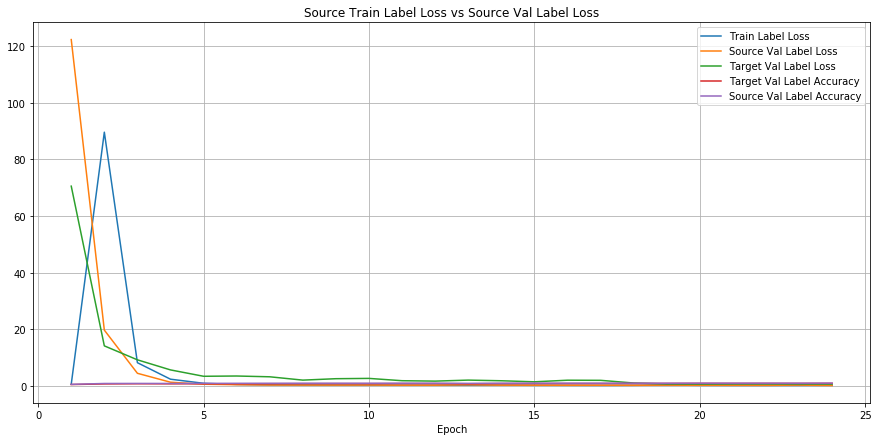

In [16]:
ax = get_loss_curve(experiment)
plt.show()

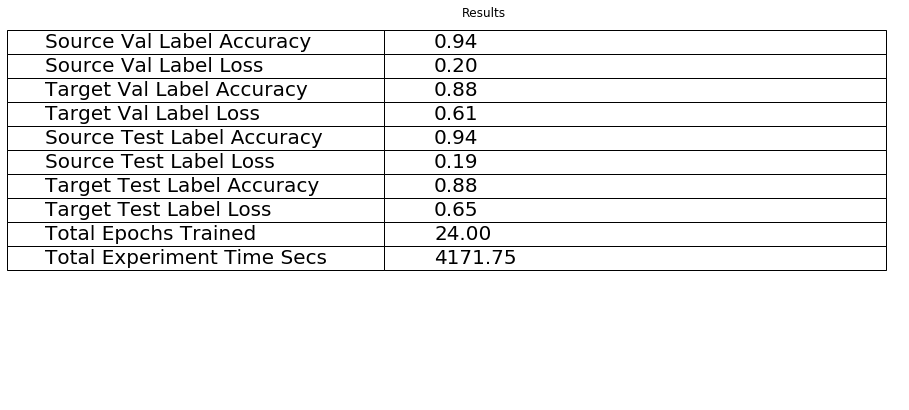

In [17]:
get_results_table(experiment)

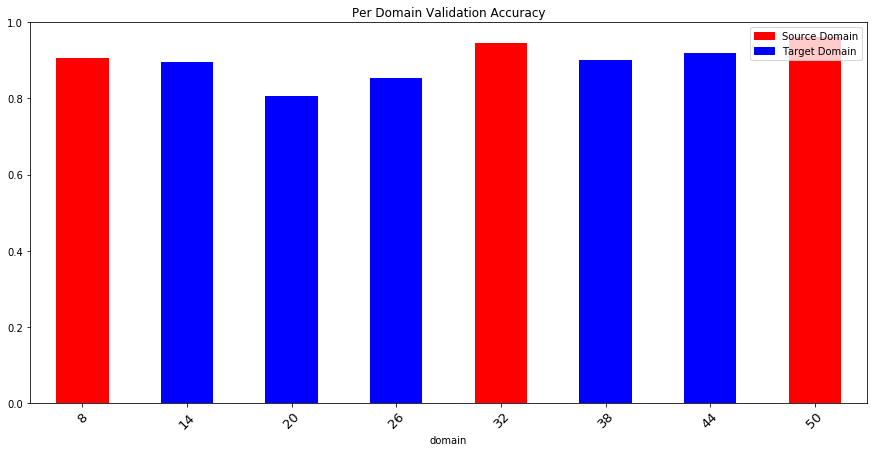

In [18]:
get_domain_accuracies(experiment)

In [19]:
print("Source Test Label Accuracy:", experiment["results"]["source_test_label_accuracy"], "Target Test Label Accuracy:", experiment["results"]["target_test_label_accuracy"])
print("Source Val Label Accuracy:", experiment["results"]["source_val_label_accuracy"], "Target Val Label Accuracy:", experiment["results"]["target_val_label_accuracy"])

Source Test Label Accuracy: 0.9407986111111111 Target Test Label Accuracy: 0.8760416666666667
Source Val Label Accuracy: 0.9375 Target Val Label Accuracy: 0.8753125


In [20]:
json.dumps(experiment)

'{"experiment_name": "baseline_ptn_oracle.run2.framed", "parameters": {"experiment_name": "baseline_ptn_oracle.run2.framed", "lr": 0.001, "device": "cuda", "seed": 1337, "dataset_seed": 1337, "labels_source": ["3123D52", "3123D65", "3123D79", "3123D80", "3123D54", "3123D70", "3123D7B", "3123D89", "3123D58", "3123D76", "3123D7D", "3123EFE", "3123D64", "3123D78", "3123D7E", "3124E4A"], "labels_target": ["3123D52", "3123D65", "3123D79", "3123D80", "3123D54", "3123D70", "3123D7B", "3123D89", "3123D58", "3123D76", "3123D7D", "3123EFE", "3123D64", "3123D78", "3123D7E", "3124E4A"], "x_transforms_source": [], "x_transforms_target": [], "episode_transforms_source": [], "episode_transforms_target": [], "num_examples_per_domain_per_label_source": 1000, "num_examples_per_domain_per_label_target": 1000, "n_shot": 3, "n_way": 16, "n_query": 2, "train_k_factor": 1, "val_k_factor": 2, "test_k_factor": 2, "torch_default_dtype": "torch.float64", "n_epoch": 50, "patience": 3, "criteria_for_best": "target